# <center> An Introduction to Deep Learning With Python <center/>

### [6.4] A temperature-forecasting problem
Prof. Yuzo Iano

pgs: 207 - 220

#### Inspecting the data of the Jena weather dataset
The dataset was download from https://www.kaggle.com/stytch16/jena-climate-2009-2016/version/1

In [1]:
import os

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


#### Parsing the data

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#### Plotting the temperature timeseries

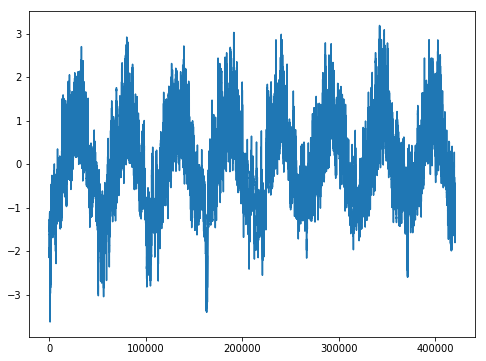

In [21]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.figure(figsize=(8, 6))
plt.plot(range(len(temp)), temp)

#### Plotting the first 10 days of the temperature timeseries

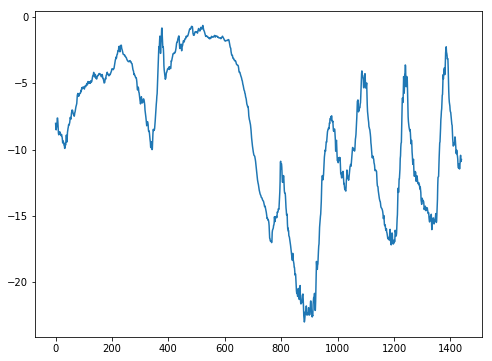

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(range(1440), temp[:1440])

#### Normalizing the data

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

#### Generator yielding timseries samples and their targets

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### Preparing the training, validation, and test generators

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size


test_steps = (len(float_data) - 300001 - lookback) // batch_size

#### Computing the common-sense baseline MAE

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


#### Converting the MAE back to a Celsius error

In [9]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

#### Training and evaluating a densely connected model

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 22s 44ms/step - loss: 1.5640 - val_loss: 0.7385
Epoch 2/20
500/500 [==============================] - 22s 44ms/step - loss: 0.5444 - val_loss: 0.3309
Epoch 3/20
500/500 [==============================] - 25s 51ms/step - loss: 

#### Plotting results

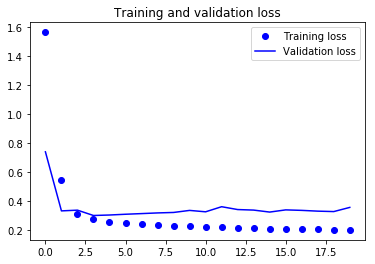

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### A first recurrent baseline
##### Training and evaluating a GRU-based model

In [12]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 99s 197ms/step - loss: 0.3057 - val_loss: 0.2730
Epoch 2/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2878 - val_loss: 0.2743
Epoch 3/20
500/500 [==============================] - 96s 193ms/step - loss: 0.2804 - val_loss: 0.2651
Epoch 4/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2752 - val_loss: 0.2707
Epoch 5/20
500/500 [==============================] - 92s 183ms/step - loss: 0.2683 - val_loss: 0.2649
Epoch 6/20
500/500 [=

#### Plotting results

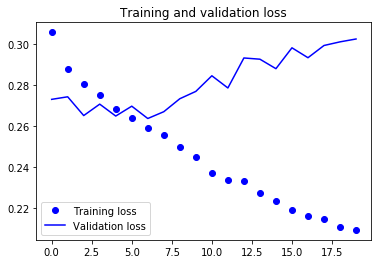

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Using recurrent dropout to fight overfitting
##### Training and evaluating a dropout-regularized GRU-based model

In [14]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 73s 145ms/step - loss: 0.3379 - val_loss: 0.2750
Epoch 2/40
500/500 [==============================] - 73s 146ms/step - loss: 0.3150 - val_loss: 0.2707
Epoch 3/40
500/500 [==============================] - 70s 140ms/step - loss: 0.3096 - val_loss: 0.2720
Epoch 4/40
500/500 [==============================] - 70s 140ms/step - loss: 0.3066 - val_loss: 0.2694
Epoch 5/4

#### Plotting results

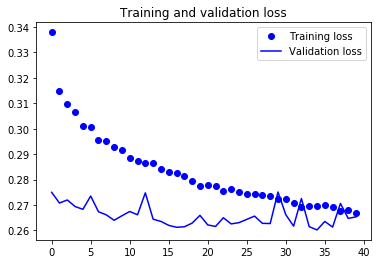

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Training and evaluating a dropout-regularized, stacked GRU model

In [16]:
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 225s 449ms/step - loss: 0.3343 - val_loss: 0.2783
Epoch 2/40
500/500 [==============================] - 223s 447ms/step - loss: 0.3116 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 224s 448ms/step - loss: 0.3053 - val_loss: 0.2709
Epoch 4/40
500/500 [==============================] - 224s 448ms/step - loss: 0.3015 - val

#### Plotting results

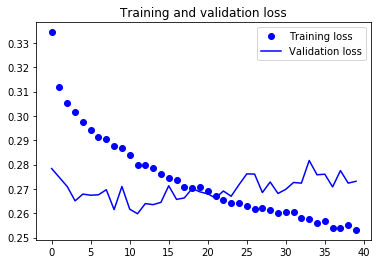

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Using bidirectional RNNs
You need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets).

In [18]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 64s 128ms/step - loss: 0.4767 - val_loss: 0.4909
Epoch 2/20
500/500 [==============================] - 72s 144ms/step - loss: 0.4442 - val_loss: 0.4610
Epoch 3/20
500/500 [==============================] - 62s 125ms/step - loss: 0.4088 - val_loss: 0.4651
Epoch 4/20
500/500 [==============================] - 66s 132ms/step - loss: 0.3719 - val_loss: 0.4623
Epoch 5/20
500/500 [==============================] - 64s 128ms/step - loss: 0.3378 - val_loss: 0.4552
Epoch 6/20
500/500 [=

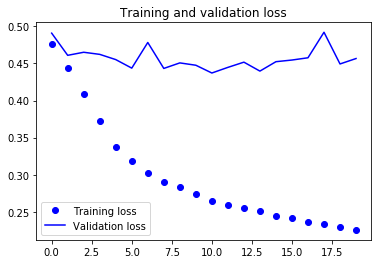

In [19]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Training a bidirectional GRU

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 92s 185ms/step - loss: 0.2929 - val_loss: 0.2665
Epoch 2/40
500/500 [==============================] - 95s 190ms/step - loss: 0.2746 - val_loss: 0.2658
Epoch 3/40
500/500 [==============================] - 93s 186ms/step - loss: 0.2661 - val_loss: 0.2642
Epoch 4/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2603 - val_loss: 0.2677
Epoch 5/40
500/500 [==============================] - 91s 181ms/step - loss: 0.2543 - val_loss: 0.2699
Epoch 6/40
500/500 [=

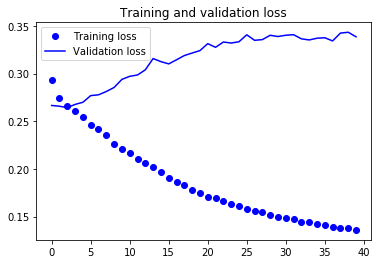

In [23]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###### Pablo Minango
* pablodavid218@gmail.com 